## 1. Raw Data

Based on data from [Jaguar movement database](https://esajournals.onlinelibrary.wiley.com/doi/full/10.1002/ecy.2379), with additional information obtained from: [H3: Uber’s Hexagonal Hierarchical Spatial Index](https://www.uber.com/en-IT/blog/h3/), [NASA: Shuttle Radar Topography Mission (SRTM)](https://www.earthdata.nasa.gov/data/instruments/srtm) and [NASA: Climate indicators](https://www.earthdata.nasa.gov/topics/climate-indicators), the dataset was constructed.

In [ ]:
import pandas as pd
import numpy as np
import math
from sklearn.cluster import DBSCAN
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [9]:
df  = pd.read_csv('data_pa_gc_final_2.csv')

#### Aditional Functions

In [11]:
#Calculate the distance in meters between two points (lat1, lon1) and (lat2, lon2) using the Haversine formula.
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 6371000  # Radio de la Tierra en metros
    return c * r

#Calculate the azimuth (angle in degrees) between two points.
def calculate_azimuth(lat1, lon1, lat2, lon2):
    # Convertir grados a radianes
    lat1_rad = math.radians(lat1)
    lat2_rad = math.radians(lat2)
    diffLong = math.radians(lon2 - lon1)
    
    # Fórmula para calcular el rumbo
    x = math.sin(diffLong) * math.cos(lat2_rad)
    y = math.cos(lat1_rad) * math.sin(lat2_rad) - math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(diffLong)
    initial_bearing = math.atan2(x, y)
    
    # Convertir de radianes a grados y normalizar el resultado a [0, 360)
    initial_bearing_deg = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing_deg + 360) % 360
    return compass_bearing

### 2. Data preparation and Feature engineering

In [12]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['timestamp_D'] = pd.to_datetime(df['timestamp_D'], errors='coerce')

In [13]:
df = df.sort_values(by=['ID_individual_identifier', 'timestamp'])

In [17]:
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek  # 0: lunes, 6: domingo
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year

In [18]:
pd.crosstab(df['ID_individual_identifier'], df['year'])

year,2009,2010,2011,2014,2015
ID_individual_identifier,,,,,
1,0,279,9,0,0
3,148,0,0,0,0
4,0,0,500,0,0
5,280,0,0,0,0
7,0,0,621,0,0
9,0,0,0,1018,0
10,0,0,0,1132,536
11,0,0,0,630,283


In [ ]:

#df = pd.read_csv("your_data.csv", parse_dates=["timestamp", "timestamp_D"])

# Create derived time features: hour of the day and season (based on month)
df['hour'] = df['timestamp'].dt.hour
df = df.dropna()
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

df['season'] = df['timestamp'].dt.month.apply(get_season)

# Function to calculate the haversine distance (in kilometers) between two points
def haversine(lon1, lat1, lon2, lat2):
    R = 6371.0  # Earth radius in km
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# Sort data by animal ID and timestamp to compute sequential movement features
df = df.sort_values(['ID_individual_identifier', 'timestamp'])

# Compute previous location and time for each individual
df['prev_long'] = df.groupby('ID_individual_identifier')['location_long'].shift(1)
df['prev_lat'] = df.groupby('ID_individual_identifier')['location_lat'].shift(1)
df['prev_time'] = df.groupby('ID_individual_identifier')['timestamp'].shift(1)

# Compute time difference in hours
df['time_diff'] = (df['timestamp'] - df['prev_time']).dt.total_seconds() / 3600.0

# Compute distance between successive points
df['distance'] = haversine(df['prev_long'], df['prev_lat'], df['location_long'], df['location_lat'])

# Compute speed (km/h); handle divisions by zero and missing values
df['speed'] = (df['distance'] / df['time_diff']).replace([np.inf, -np.inf], np.nan).fillna(0)

# At this point, you could also compute additional features like turning angles if desired.

# Select features for the behavioral analysis.
# Here, we include speed, hour, and the climate variables: T2M, RH2M, WS10M, PS, PRECTOTCORR, and altitud.
features = df[['speed', 'hour', 'T2M', 'RH2M', 'WS10M', 'PS', 'PRECTOTCORR', 'altitud']].copy()

# Scale features to ensure they contribute equally
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply UMAP to reduce dimensions to 2D for visualization
umap_reducer = umap.UMAP(n_components=2, random_state=42)
embedding = umap_reducer.fit_transform(features_scaled)

# Add UMAP embedding coordinates to the DataFrame
df['umap_x'] = embedding[:, 0]
df['umap_y'] = embedding[:, 1]


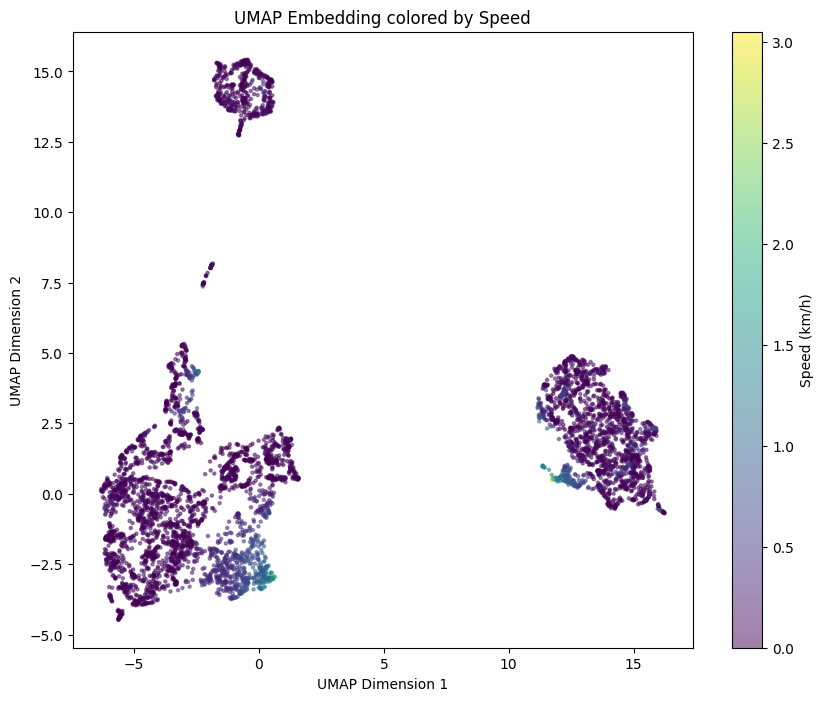

C:\Users\renzo\AppData\Local\Temp\ipykernel_101432\773544916.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10', len(unique_clusters))


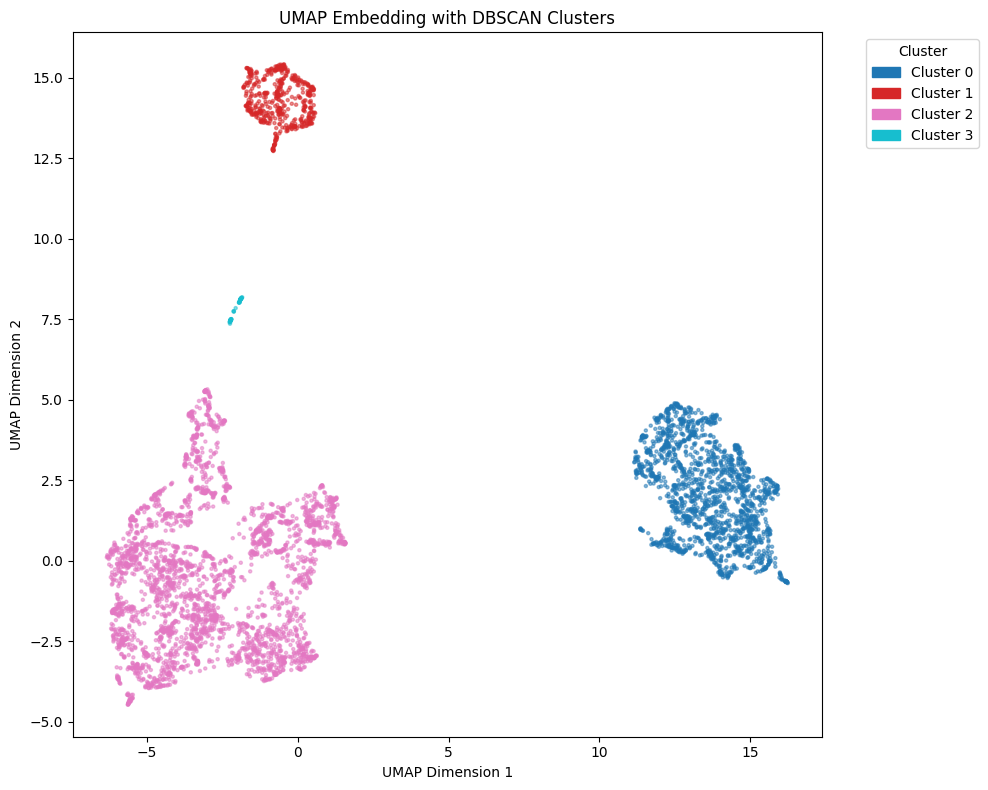

            speed        T2M       RH2M     WS10M          PS  PRECTOTCORR  \
cluster                                                                      
0        0.175544  -4.118130  90.338595  9.922912   99.391853     2.776878   
1        0.072699  24.714843  70.512736  3.947972  100.170551     2.208642   
2        0.165843  25.683298  69.235818  4.064972  100.102154     2.488954   
3        0.217307  25.390426  80.751064  4.976596   99.794894    47.011277   

           altitud  
cluster             
0        88.609632  
1        87.964567  
2        88.018141  
3        87.638298  


In [ ]:

import matplotlib.patches as mpatches
# Visualize the UMAP embedding; color-code by speed (or another variable of interest)
plt.figure(figsize=(10, 8))
plt.scatter(df['umap_x'], df['umap_y'], s=5, alpha=0.5, c=df['speed'], cmap='viridis')
plt.title("UMAP Embedding colored by Speed")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="Speed (km/h)")
plt.show()

# Optionally, you can apply a clustering algorithm (e.g., DBSCAN) on the embedding to find behavioral clusters.
clustering = DBSCAN(eps=0.5, min_samples=10).fit(embedding)
df['cluster'] = clustering.labels_

clustering = DBSCAN(eps=0.5, min_samples=10).fit(embedding)
df['cluster'] = clustering.labels_

# Scatterplot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['umap_x'], df['umap_y'], s=5, alpha=0.5, c=df['cluster'], cmap='tab10')

# Clusters
unique_clusters = np.unique(df['cluster'])
color_map = plt.cm.get_cmap('tab10', len(unique_clusters))

legend_elements = [mpatches.Patch(color=color_map(i), label=f'Cluster {cluster}')
                   for i, cluster in enumerate(unique_clusters)]

plt.legend(handles=legend_elements, title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("UMAP Embedding with DBSCAN Clusters")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.tight_layout() 
plt.show()

# Results exploration
cluster_summary = df.groupby('cluster')[['speed', 'T2M', 'RH2M', 'WS10M', 'PS', 'PRECTOTCORR', 'altitud']].mean()
print(cluster_summary)
